# <font  color = "#0093AF"> Experimental Settings and Spin-System Definition

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter1/Ch1_expsys.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

## Setup

In [0]:
# SETUP SLEEPY

In [2]:
import SLEEPY as sl
import numpy as np
import matplotlib.pyplot as plt

## Defining nuclei and experimental conditions

The experimental system defines the magnetic field, the nuclei in the spin-system, the spinning rate, the temperature, the rotor angle, the powder average, and the number of gamma angles calculated during one rotor period. Except for the field and nuclei, these all have default values and only need to be provided if other values are needed.

- v0H: The magnetic field strength, given as the $^1$H frequency in MHz (required, unless B0 provided)
- B0: The magnetic field strength in Tesla (required, unless v0H provided)
- Nucs: List of nuclei, with mass number followed by atomic symbol ('1H','13C','2H', etc.). Electrons may also be included via 'e-'. To obtain a high-spin electron, start with e and follow with the spin. For example, specifying 'e1' would give an electron with spin 1, and 'e3/2' or 'e1.5' would produce an electron with spin-3/2.
- T_K: Temperature in Kelvin. Only used if relaxation to thermal equilibrium is used (thermalization), or the density matrix (rho) is initialized with the "thermal" option. Default is 298 K.
- vr: Spinning frequency in Hz (only used if anisotropic interactions provided). Default is 10000
- rotor_angle: Rotor angle, in radians. Default is the magic angle
- n_gamma: Number of gamma angles calculated per rotor period. For string-specified powder averages (i.e. not JCP59 or grid), this is also the number of gamma angles in the powder average. Default is 100
- pwdavg: Type of powder average. Type sl.PowderAvg.list_powder_types to see options (Most powder averages from SIMPSON). If an integer is provided, then this yields the JCP59 powder average, with higher integers yielding more angles. Defaults is 3 (JCP59 with 99 angles)
- LF: Specifiy whether each spin should be simulated in the lab frame. Can be provided as a single boolean, e.g. False sets all spins in the rotating frame, or as a list the same length as Nucs, which puts some spins in the lab frame and some in the rotating frame (useful, e.g. for DNP experiments such as solid-effect/cross-effect where the electrons should be in the rotating frame, but the nucleus in the lab frame).

In [3]:
ex=sl.ExpSys(v0H=600,Nucs=['1H','13C'],vr=10000,T_K=298,
             rotor_angle=np.arccos(np.sqrt(1/3)),n_gamma=100,
             pwdavg=3,LF=[False,False])

Typing `ex` at the command line will return a description of the experimental setup.

In [4]:
ex

2-spin system (1H,13C)
B0 = 14.092 T (600.000 MHz 1H frequency)
rotor angle = 54.736 degrees
rotor frequency = 10.0 kHz
Temperature = 298 K
Powder Average: JCP59 with 99 angles
Interactions:


Note that we have used the default values, so the same system may be obtained while omitting all the defaults:

In [5]:
ex=sl.ExpSys(v0H=600,Nucs=['1H','13C'])

## Defining Interactions
Once the experimental settings and spin-system is set, we may add interactions. This is achieved by running
```
ex.set_inter(...)
```
For every interaction, we have to specify the spins involved. For an N-spin system, this is specified with an index (spin-field) or indices (spin-spin) referring to the spin at the corresponding position in Nucs. Note we use python convention of indexing from 0 to N-1. For spin-field interactions, we specify "i", and for spin-spin interactions, we specify "i0" and "i1". The available interactions are:

- dipole: Specify delta (the full anisotropy in Hz, which is 2x the definition used by SIMPSON). Optionally specify an asymmetry, eta (unitless) and the euler angles, euler as a 3-element (alpha,beta,gamma) list in radians.
- J: Specify J in Hz.
- CS: Isotropic chemical shift, specify in ppm (use `ppm=...`) or in Hz (use `Hz=...`). 
- CSA: Chemical shift anisotropy. Specify delta in ppm (`delta=...`) or in Hz (`deltaHz=...`). eta and the euler angles are optional.
- hyperfine: Specify Axx, Ayy, and Azz. If all entries are equal, will be treated as an isotropic interaction. "euler" may be optionally provided.
- quadrupole: Specify delta in Hz. Note that this is not the peak-to-peak splitting, but rather the tensor anisotropy (as is always the case in SLEEPY). Optionally specify eta and euler
- g: Electron g-tensor. Specify gxx, gyy, and gzz, and optionally euler.
- ZeroField: Electron zero-field. Specify D and optionally E (both in Hz), and optionally euler.

In [6]:
ex=sl.ExpSys(v0H=600,Nucs=['1H','13C'],pwdavg='rep678')
delta=sl.Tools.dipole_coupling(.109,'1H','13C')  #Calculate H-C dipole for 1.05 Angstrom distance
ex.set_inter('dipole',i0=0,i1=1,delta=delta,euler=[0,np.pi/4,0]) #H-C dipole coupling
ex.set_inter('CSA',i=1,delta=100,eta=1) #13C CSA
_=ex.set_inter('CS',i=0,ppm=10) #1H isotropic chemical shift

We can view the shape of the tensors with the "plot_inter" function. Note that this results in a scatter plot, where the number of points is determined by the powder average. What is shown is the magnitude (as distance from the origin) and phase (as color). For the $n=0$ component, only real values are possible, so we only see positive (red) and negative (blue).

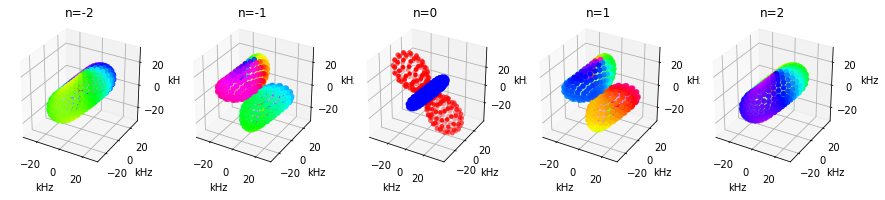

In [8]:
fig=plt.figure(figsize=[15,8])
ax=[fig.add_subplot(1,5,k+1,projection='3d') for k in range(5)]
for k,a in enumerate(ax):ex.plot_inter(0,n=k-2,ax=a)

Note, if we try to plot an isotropic term, we just obtain a sphere.

<Axes3DSubplot:title={'center':'n=0'}, xlabel='Hz', ylabel='Hz'>

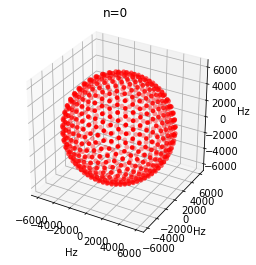

In [11]:
ex.plot_inter(2,n=0)

When setting an interaction, ex returns itself. This lets us string together multiple commands, for example, the following line will achieve the same interactions as above. Note that if an interaction is defined twice for the same spin or spins, the former definition will be overwritten.

In [5]:
_=ex.set_inter('dipole',i0=0,i1=1,delta=delta,euler=[0,np.pi/4,0]).set_inter('CSA',i=1,delta=100,eta=1).\
    set_inter('CS',i=0,ppm=10)

If we just type 'ex' at the command line, we will obtain a description of the experimental system

In [6]:
ex

2-spin system (1H,13C)
B0 = 14.092 T (600.000 MHz 1H frequency)
rotor angle = 54.736 degrees
rotor frequency = 10.0 kHz
Temperature = 298 K
Powder Average: JCP59 with 99 angles
Interactions:
	dipole between spins 0,1 with arguments:
		(delta=52194.25)
	CSA on spin 1 with arguments: (delta=100.00,eta=1.00)
	CS on spin 0 with arguments: (ppm=10.00)


## Functions and contents of ExpSys

The ExpSys object, ex, contains various useful pieces of information (both to the user, and the program). For example:

- ex.B0: Magnetic field
- ex.Nucs: Nuclei/electrons in spin-system
- ex.S: Spins of nuclei in spin-system
- ex.Peq: Thermal polarization of spins in spin-system (based on Larmor frequency only)
- ex.gamma: Gyromagnetic ratio of spins in spin-system
- ex.v0: Larmor frequency of spins in spin-system
- ex.vr: Rotor frequency
- ex.taur: Rotor period
- ex.rotor_angle: rotor angle
- ex.inter: List of all interactions entered

It also contains a number of functions

- ex.copy: Returns a copy of ex (useful for building exchange calculations, where interactions may change due to exchange, but things like the field, Nuclei, etc. should remain fixed)
- ex.Hamiltonian: Returns a Hamiltonian object for the spin-system
- ex.Liouvillian: Returns a Liouvillian object for the spin-system

Finally, it contains important objects

- ex.pwdavg: Powder average object for the spin-system. Note, if all interactions are isotropic, when a Liouvillian or Hamiltonian is created, the powder average will be replaced with a 1-element powder-average.
- ex.Op: Spin-operator object, which contains the spin-operators for the spin-system

## The powder average

The powder average can be changed, by simply replacing the powder average object (can be generated from sl.PowderAvg), or by running the function pwdavg.set_pwd_type. Note that this needs to be done before calculating propagators.
```
ex.pwdavg=sl.PowderAvg('rep144',gamma_encoded=True)
ex.pwdavg.set_powder_type('rep144',gamma_encoded=True)
```
Both would set the powder average to a repulsion powder average with 144 alpha and beta angles. Setting gamma_encode to True will skip the average over gamma_angles, which speeds up some calculations considerably, but will return incorrect results for pulse sequences that are not gamma encoded (e.g. REDOR).

The powder average object contains useful information about how to execute the powder average. For example:
- pwdavg.PwdType : Type of powder average used
- pwdavg.N : Number of angles in the powder average
- pwdavg.alpha : alpha angles
- pwdavg.beta : beta angles
- pwdavg.gamma : gamma angles
- pwdavg.weight : weight to use when summing the powder average
- pwdavg.gamma_encoded : Boolean, determines whether averaging over gamma is skipped (cannot be set except at initialization, or when running pwdavg.set_pwd_type)

In [7]:
ex.pwdavg.set_powder_type('rep256')

Typing ex.pwdavg at the command line will provide basic information about the powder average

In [8]:
ex.pwdavg

Powder Average
Type:	rep256 with 25600 angles


The powder average can also be plotted. By default, this plots the $\alpha$ and $\beta$ angles, but can be switched to $\beta$ and $\gamma$ angles by setting beta_gamma to True

<Axes3DSubplot:xlabel='x', ylabel='y'>

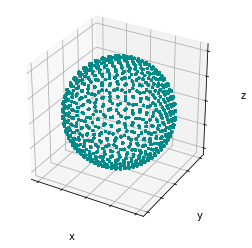

In [13]:
ex.pwdavg.plot()

## The Spin Operators

The spin operators are used to build the Hamiltonian for a given spin system. They are found in ex.Op, although one can also create a spin-operators from sl.SpinOp, with a list of spins as input. ex.Op contains basic information about the operators:

- ex.Op.N: Number of spins
- ex.Op.S: Spin number
- ex.Op.Mult: Multiplicity of each spin (2*S+1)
- ex.Hlabels/ex.Llabels: $\LaTeX$ labels for each spin state in Hilbert and Liouville space
- ex.state_index: List of states of each spin in the density matrix (used for spin-exchange)

To access the spin matrices themselves, we first provide an index to go the desired spin, and then choose the spin matrix that we want:

Possible matrices: x, y, z, alpha, beta, m ($I^-$), p ($I^+$), eye (identity matrix)



In [14]:
ex.Op[0].x  #Example: x operator for the 0th spin

array([[0. +0.j, 0. +0.j, 0.5+0.j, 0. +0.j],
       [0. +0.j, 0. +0.j, 0. +0.j, 0.5+0.j],
       [0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j],
       [0. +0.j, 0.5+0.j, 0. +0.j, 0. +0.j]])

We also have access to the coherence order of each element of the matrix (ex.Op[0].coherence_order).

Finally, we have access to the matrices for spherical tensors, via e.g. ex.Op[0].T. T can be be indexed to give the rank 0, rank 1, and rank 2 (if spin-1 or higher) operators. The resulting list contains the operators running from the lowest to highest index.

So, ex.Op[0].T[1][0] returns $T_{1,-1}^{(0)}$, that is the rank $m=-1$ component of the rank-1 tensor for spin 0.

In [47]:
ex.Op[0].T[1][0] #eg m=-1 component of the rank-1 tensor for spin 0

array([[-0. +0.j, -0. +0.j, -0. +0.j, -0. +0.j],
       [-0. +0.j, -0. +0.j, -0. +0.j, -0. +0.j],
       [-0.5+0.j, -0. +0.j, -0. +0.j, -0. +0.j],
       [-0. +0.j, -0.5+0.j, -0. +0.j, -0. +0.j]])

However, what we usually need for building Hamiltonians is the rank-2 spherical tensors. For 1-spin tensors, these are obtained first by changing the mode of the spherical tensor to 'B0_LF', for example:

In [50]:
ex.Op[0].T.set_mode('B0_LF')
ex.Op[0].T[2]

[array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
        [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
        [0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j],
        [0. +0.j, 0.5+0.j, 0. +0.j, 0. +0.j]]),
 array([[ 0.40824829+0.j,  0.        +0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j,  0.40824829+0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j,  0.        +0.j, -0.40824829+0.j,
         -0.        +0.j],
        [ 0.        +0.j,  0.        +0.j, -0.        +0.j,
         -0.40824829+0.j]]),
 array([[-0. +0.j, -0. +0.j, -0.5+0.j, -0. +0.j],
        [-0. +0.j, -0. +0.j, -0. +0.j, -0.5+0.j],
        [-0. +0.j, -0. +0.j, -0. +0.j, -0. +0.j],
        [-0. +0.j, -0. +0.j, -0. +0.j, -0. +0.j]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])]

For spin-spin interactions, we need to multiply the spin-operators together and also define whether both spins are in the rotating frame or lab frame. For example, if the first spin is in the lab frame and second in the rotating frame, we use:

In [58]:
T2spin=ex.Op[0].T*ex.Op[1].T
T2spin.set_mode('LF_RF')
T2spin[2]

[array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[-0.  +0.j, -0.  +0.j, -0.25+0.j, -0.  +0.j],
        [-0.  +0.j, -0.  +0.j, -0.  +0.j,  0.25-0.j],
        [-0.  +0.j, -0.  +0.j, -0.  +0.j, -0.  +0.j],
        [-0.  +0.j, -0.  +0.j, -0.  +0.j, -0.  +0.j]]),
 array([[ 0.20412415+0.j,  0.        +0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j, -0.20412415+0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j,  0.        +0.j, -0.20412415+0.j,
          0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
          0.20412415+0.j]]),
 array([[ 0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j],
        [ 0.  +0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j],
        [ 0.25+0.j,  0.  +0.j,  0.  +0.j,  0.  +0.j],
        [ 0.  +0.j, -0.25+0.j,  0.  +0.j,  0.  +0.j]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])]

If both spins are in the rotating frame, then we need to define if this is a homonuclear ('homo') or heteronuclear ('het') interaction. If we compare the results, we see that off-diagonal terms emerge for the homonuclear interaction, but not for the heternuclear interaction.

In [59]:
T2spin.set_mode('homo')
T2spin[2]

[array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[ 0.20412415+0.j,  0.        +0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j, -0.20412415+0.j, -0.20412415+0.j,
          0.        +0.j],
        [ 0.        +0.j, -0.20412415+0.j, -0.20412415+0.j,
          0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
          0.20412415+0.j]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])]

In [60]:
T2spin.set_mode('het')
T2spin[2]

[array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[ 0.20412415+0.j,  0.        +0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j, -0.20412415+0.j,  0.        +0.j,
          0.        +0.j],
        [ 0.        +0.j,  0.        +0.j, -0.20412415+0.j,
          0.        +0.j],
        [ 0.        +0.j,  0.        +0.j,  0.        +0.j,
          0.20412415+0.j]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]),
 array([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])]

SLEEPY uses the full set of spherical tensors (`T`) when operating in the lab frame, but just the rank-2, $m=0$ component in the rotating frame (and this is not usually inserted with the spherical components).